In [219]:
#Code :
# Lab 6 (i): BS,BIN,CV price
# Lab 6 (ii) : MC with no discretization
# Lab 6 Q3 : Barrier 1 (method 1)
# Lab 6 Q3 : Barrier 2 (method 2)
#
# Lab 7 (i) : Delta and Std of Option
# Lab 7 (ii) : Delta and Variance of Portfolio
#Lab 8 : X
#Lab 9 : CV,AV,FD
#Lab 10 : FD

In [213]:
# Lab 6 (i)
# Practice 2 exercise 1
#MC option pricing (dt)
#BS price, Tree price, CV price
#pricing american bs using control variate technique

# --- Define Libraries -------------------------------------------------
import math as m
from scipy.stats import norm
import numpy as np

# --- Define Input Data -------------------------------------------------
cp = -1     # +1/-1 for Call/Put
ae = +1     # +1/-1 for American/European
S	= 20
K	= 28
r	= 0.04
T	= 1
sigma	= 0.35
n = 100

# --- Calculation Other Values ----------------------------------------------
dt = T / n              # <- h
u = m.exp(sigma * dt**0.5)
d = 1 / u
f = (m.exp(r * dt) - d) / (u - d)        

# --- Define Result Matrix --------------------------------------------------
opt_val_A = np.zeros((n+1, n+1))
opt_val_E = np.zeros((n+1, n+1))
S_val = np.zeros((n+1, n+1))

# --- Define Score Functions  ------------------------------------------------
def CallOptionValue(S, K, r, sigma, T):
	d1 = (m.log(S/K) + (r + 0.5 * sigma**2) * T)/(sigma * m.sqrt(T))
	d2 = d1 - sigma * m.sqrt(T)
	return S * norm.cdf(d1) - K * m.exp(-r*T) * norm.cdf(d2)
def PutOptionValue(S, K, r, sigma, T):
	d1 = (m.log(S/K) + (r + 0.5 * sigma**2) * T)/(sigma * m.sqrt(T))
	d2 = d1 - sigma * m.sqrt(T)
	return K * m.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Generate the Underlying Stock Price ----------------------------------------
S_val[0,0] = S
for i in range(1,n+1):
    S_val[i,0] = S_val[i-1,0] * u
    for j in range(1,i+1):
        S_val[i,j] = S_val[i-1,j-1] * d
            
# Backward recursion for option price ----------------------------------------
for j in range(n+1):
    opt_val_A[n,j] = max(0, cp*( S_val[n,j]-K ))
    opt_val_E[n,j] = max(0, cp*( S_val[n,j]-K ))
for i in range(n-1,-1,-1):
    for j in range(i+1):
        opt_val_E[i,j] = ( f * opt_val_E[i+1,j] + (1-f) * opt_val_E[i+1,j+1] ) / m.exp(r * dt)
        opt_val_A[i,j] = ( f * opt_val_A[i+1,j] + (1-f) * opt_val_A[i+1,j+1] ) / m.exp(r * dt)
        opt_val_A[i,j] = max( opt_val_A[i,j], cp * (S_val[i,j] - K) )
            
if cp == 1:
    BSpriceEU = CallOptionValue(S, K, r, sigma, T)
    Call_or_Put = 'Call'
else:
    BSpriceEU = PutOptionValue(S, K, r, sigma, T)
    Call_or_Put = 'Put'
BSpriceA =  opt_val_A[0,0] + BSpriceEU - opt_val_E[0,0] #!!!  ###CV BSA price

print('The BS price of the European',Call_or_Put, 'option is %.5f.' % BSpriceEU)
print('The Tree price of the European',Call_or_Put, 'option is %.5f.' % opt_val_E[0,0])
print('The Tree price of the American',Call_or_Put, 'option is %.5f.' % opt_val_A[0,0])
print('The control variate price of the American', Call_or_Put, 'option is %.5f.' % BSpriceA)

The BS price of the European Put option is 7.79142.
The Tree price of the European Put option is 7.79078.
The Tree price of the American Put option is 8.24051.
The control variate price of the American Put option is 8.24115.


In [217]:
# Lab 6 (ii)
#Exercise 2
# OPTION PRICING WITH MC
# MC with no discretization (no dt)

#--- Define Library --------------------------------
import math as m
import numpy as np
import matplotlib.pyplot as plt

#--- Define Input Data -----------------------------
cp = -1 # +1/-1 for Call/Put
S = 60
K = 65
r = 0.08
T = 0.25
sigma = 0.3
nr = 1000
n= 100 #no. of time steps (not in solutions)

#--- Calculation Other Values ------------------------
nu = r - 0.5 * sigma**2

#--- Define Result Matrix -----------------------------
FinPayOff = np.zeros(( nr, 1)) #nr rows, one column
S_val = np.zeros((nr, 1))
rand = np.random.randn(nr, 1)

#--- Process the Monte Carlo Method ------------------
for i in range(nr):
    S_val[i,0] = S * m.exp(nu*T + sigma * T**0.5 * rand[i,0])

#--- Mean of Monte Carlo results for option price -----
FinPayOff = np.maximum(cp*(S_val[:,-1] - K), 0)
PDisc = np.exp( -r * T ) * FinPayOff
price = PDisc.mean()
std = np.std(PDisc)
    
print('The price of the Monte Carlo Method with', nr, 'simulations is %.5f.' % price)
print('The standard deviation is %.5f.' % std)

The price of the Monte Carlo Method with 1000 simulations is 5.68328.
The standard deviation is 5.80638.


The price of the Monte Carlo Method with 500 simulations is 1.01116.
The standard deviation is 2.15003.
The option is exercised 130 times


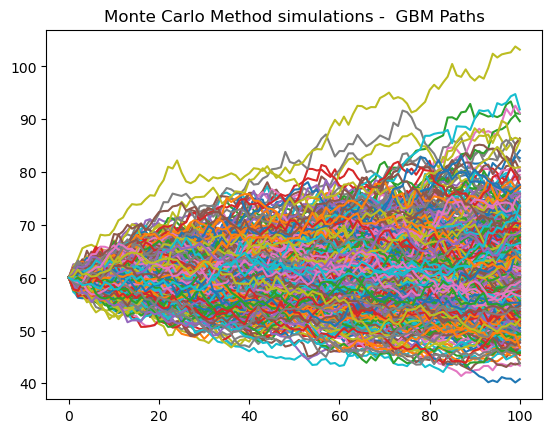

In [77]:
# Lab 6 (iii)
#BARRIER 1

# --- Define Library          -----------------------------------------------
import math as m
import numpy as np
import matplotlib.pyplot as plt

# --- Define Input Data       -------------------------------------------------
S	= 60
K	= 65
r	= 0.08
T	= 0.25
sigma	= 0.3

# n DEFINES THE TIME STEP
n = 100
# nr is the number of simulations
nr = 500

# --- Calculation Other Values   ----------------------------------------------
# Here we refer to the risk-neutral valuation.
nu = r - 0.5 * sigma**2
dt = T / n              # <- h

# --- Define Result Matrix    -------------------------------------------------
FinPayOff = np.zeros(( nr, 1))
S_val = np.zeros((nr, n+1))
rand = np.random.randn(nr, n)
   
# Process the Monte Carlo Method ----------
S_val[:,0] = S
for i in range(nr):
    for j in range(1,n+1):
        S_val[i,j] = S_val[i,j-1] * m.exp(nu*dt + sigma * dt**0.5 * rand[i,j-1])
            
# Mean of Monte Carlo results for option price -----
FinPayOff = np.maximum((S_val[:,-1] - K), 0)
counter = 0

#if the price at expiry is over 75, we have a payoff greater than 10 (75 is £10 above K = 65)
for i in range(nr):#the accounts for upper and lower barrier !!!
    if FinPayOff[i] > 10:
       FinPayOff[i] = 0
    if FinPayOff[i] > 0:
        counter = counter + 1
       
PDisc = np.exp( -r * T ) * FinPayOff
price = PDisc.mean()
std = np.std(PDisc)
    
# Plot ----
plt.figure()
for i in range(nr):
    plt.plot(S_val[i,:])
plt.title('Monte Carlo Method simulations -  GBM Paths')
    
print('The price of the Monte Carlo Method with', nr, 'simulations is %.5f.' % price)
print('The standard deviation is %.5f.' % std)
print('The option is exercised', counter ,'times')

The price of the Monte Carlo Method with 500 simulations is 0.96658.
The standard deviation is 2.24645.
The option is exercised 114 times


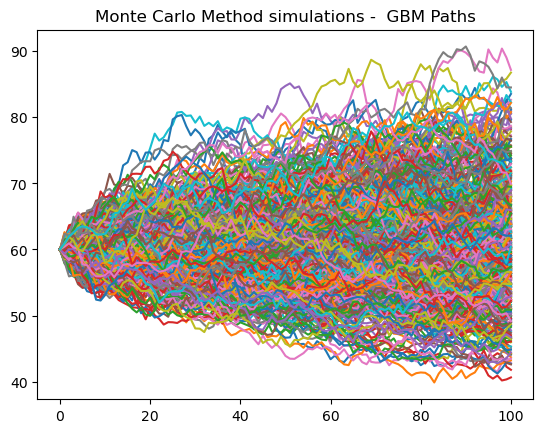

In [87]:
# Lab 6 (iv)
# BARRIER 2
#same as barrier one except one line marked ##########################

# MC - therefore values change every time 

# --- Define Library-----------------------------------------------
import math as m
import numpy as np
import matplotlib.pyplot as plt

# --- Define Input Data-------------------------------------------------
S	= 60
K	= 65
r	= 0.08
T	= 0.25
sigma	= 0.3

# n DEFINES THE TIME STEP
n = 100
# nr is the number of simulations
nr = 500

# --- Calculation Other Values----------------------------------------------
# Here we refer to the risk-neutral valuation.
nu = r - 0.5 * sigma**2
dt = T / n   # <- h

# --- Define Result Matrix    -------------------------------------------------
FinPayOff = np.zeros(( nr, 1))
S_val = np.zeros((nr, n+1))
rand = np.random.randn(nr, n)
   
# Process the Monte Carlo Method ----------
S_val[:,0] = S
for i in range(nr):
    for j in range(1,n+1):
        S_val[i,j] = S_val[i,j-1] * m.exp(nu*dt + sigma * dt**0.5 * rand[i,j-1])
            
# Mean of Monte Carlo results for option price ----
counter = 0
for i in range(nr):
    if 65 <= S_val[i,-1] < 75:  #upper and lower barrier ################################
       FinPayOff[i,0] = np.max(S_val[i,-1] - K, 0)
       counter = counter + 1
       
PDisc = np.exp( -r * T ) * FinPayOff
price = PDisc.mean()
std = np.std(PDisc)
    
# Plot ----
plt.figure()
for i in range(nr):
    plt.plot(S_val[i,:])
plt.title('Monte Carlo Method simulations -  GBM Paths')
    
print('The price of the Monte Carlo Method with', nr, 'simulations is %.5f.' % price)
print('The standard deviation is %.5f.' % std)
print('The option is exercised', counter ,'times')

In [3]:
# Lab 7 (i)
# DELTA AND STD OF OPTION
#question 10

import math as m
import numpy as np

# --- Define Input Data       -------------------------------------------------
S	= 60
K1	= 65
K2 = 75
r	= 0.08
T	= 0.25
sigma	= 0.3
nr = 10000

# --- Calculation Other Values ----------------------------------------------
nu = r - 0.5 * sigma**2

# --- Define Result Matrix -------------------------------------------------
Delta = np.zeros((nr, 1))
S_val = np.zeros((nr, 1))
rand = np.random.randn(nr, 1)

# --- Define Indicator Functions  -------------------------------------------------
def I1(x):           #call!!!
    if x > 0:
        return 1
    else:
        return 0

def I2(x):           #put!!!
    if x > 0:
        return 0
    else:
        return 1

# --- Main Function --------------------------------------------------
for i in range(nr):
    S_val[i,0] = S * m.exp(nu*T + sigma * T**0.5 * rand[i,0])

# option Delta results for option price ------------------------------
for i in range(nr):
    Delta[i,0] = np.exp( -r * T) * (S_val[i,0] / S ) * (- I1(S_val[i,0] - K1) - 4 * I2(S_val[i,0] - K2) +5)

mean = Delta.mean()
std = np.std(Delta)

print(('The Delta of the Call Option with %i simulations is: Delta = %.5f') % (nr, mean))
print(('The standard deviation is %.5f') % (std))

The Delta of the Call Option with 10000 simulations is: Delta = 1.03468
The standard deviation is 1.29612


In [173]:
#Lab 7 q10
#answer from the notes
#put

import math as m 
from scipy.stats import norm
import numpy as np

S = 60
K = 65
r = 0.08
T = 0.25
sigma = 0.3

nr = 1000
nu = r - 0.5 * sigma ** 2 

Delta = np.zeros((nr,1))
S_val = np.zeros((nr,1))
rand = np.random.randn(nr,1)

def I(x): #put
    if x > 0:
        return 0
    else:
        return 1

for i in range(nr): 
    S_val[i,0] = S * m.exp(nu*T + sigma * T ** 0.5 * rand[i,0])
    Delta[i,0] = -np.exp(-r*T) *(S_val[i,0]/S) * I(S_val[i,0] - K)

mean, var = norm.fit(Delta)

print(('The delta of the put option with %i simulations is: Delta = %.5f') %(nr, mean))
print(('The variance is %.5f') %(var))

The delta of the put option with 1000 simulations is: Delta = -0.63176
The variance is 0.42914


In [7]:
# Lab 7 (ii)
# DELTA AND VARIANCE OF PORTFOLIO
# question 11
import math as m
import numpy as np

# --- Define Input Data ---------------------------------------------------------
S = 50
K1 = 10
K2 = 30
r = 0.08
T = 0.25
sigma = 0.3
nr = 10000

# --- Calculation Other Values --------------------------------------------------
nu = r - 0.5 * sigma ** 2

# --- Define Result Matrix ------------------------------------------------------
Delta = np.zeros((nr, 1))
S_val = np.zeros((nr, 1))
rand = np.random.randn(nr, 1)

# --- Define Indicator Function -------------------------------------------------
def I1(x):
    if x > 0:
        return 0
    else:
        return 1

def I2(x):
    if x > 0:
        return 1
    else:
        return 0

# --- Main Function -------------------------------------------------------------
for i in range(nr):
    S_val[i,0] = S * m.exp(nu*T + sigma * T**0.5 * rand[i,0])

# option Delta results for option price -----------------------------------------
for i in range(nr):
    Delta[i,0] =   np.exp(-r * T) * (S_val[i,0] / S ) * ( I2( S_val[i,0] - K1 ) + 3 * I1( S_val[i,0] - K2 ))
port_delta = Delta.mean()
std = np.std(Delta)

print(('The Delta of the Portfolio with %i simulations is: Delta = %.5f') % (nr , port_delta))
print(('The variance is %.5f') % (std))

The Delta of the Portfolio with 10000 simulations is: Delta = 1.00008
The variance is 0.14981


The price of the Asian Option with CV Method and 1000 simulations is 112.85174.
The standard deviation of the price with CV Method and 1000 simulations is 61.15339.
The price of the Option without CV Method and 1000 simulations is 98.31788.
The standard deviation of the price withouth CV Method and 1000 simulations is 97.19781.


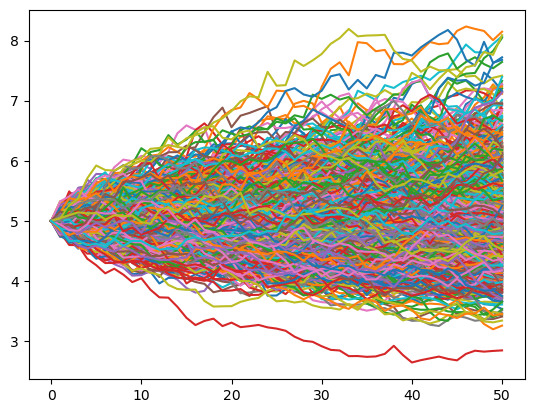

In [1]:
#Lab 9
#Antithetic Variates,Control Variates,Finite Difference Methods
# --- Define Library          -------------------------------------------------

import math as m
import numpy as np
import matplotlib.pyplot as plt

# --- Define Input Data       -------------------------------------------------
S	= 5
K	= 500
r	= 0.08
T	= 0.25
sigma	= 0.3

n = 50
nr = 1000

# --- Calculation Other Values   ----------------------------------------------

nu = r - 0.5 * sigma**2
dt = T / n

# --- Define Result Matrix    -------------------------------------------------
FinPayOff = np.zeros(( nr, 1))
S_val = np.zeros((nr, n+1))
Series = np.zeros((nr, n+1))
rand = np.random.randn(nr, n)
ControlVars = np.zeros(( nr, 1))


    
    # Process the Monte Carlo Method ----------
    
S_val[:,0] = S
for i in range(nr):
    for j in range(1,n+1):
        S_val[i,j] = S_val[i,j-1] * m.exp(nu*dt + sigma * dt**0.5 * rand[i,j-1])
        
        

FinPayOff = np.exp( -r * T ) * np.maximum(K- np.mean(S_val[:,1:]**4, 1)+2*np.mean(S_val[:,1:]**3, 1)-np.mean(S_val[:,1:]**2, 1), 0)

    # Control Variates -----
    
for i in range(nr):
    for j in range(n+1):
        Series[i,j] = (S_val[i,j]**2- S_val[i,j])**2
    
StockSum = np.sum(Series,1)
ExpSum = S**4* (( 1 - np.exp( 4*(n+1) * r * dt )) / ( 1 - np.exp(4* r * dt )))-2*S**3* (( 1 - np.exp( 3*(n+1) * r * dt )) / ( 1 - np.exp( 3*r * dt )))+S**2 * (( 1 - np.exp( (n+1) * r * dt )) / ( 1 - np.exp( r * dt )))
    
b = np.cov(StockSum, FinPayOff)[0,1] / np.var(StockSum)
    
for i in range(nr):
    ControlVars[i] = FinPayOff[i] - b * (StockSum[i] - ExpSum)
    
mean = ControlVars.mean()
std = np.std(ControlVars)
    
mean_MC = FinPayOff.mean()
std_MC = np.std(FinPayOff)
    
    # Plot ----
plt.figure()
for i in range(nr):
    plt.plot(S_val[i,:])
 
    
print('The price of the Asian Option with CV Method and', nr, 'simulations is %.5f.' % mean)
print('The standard deviation of the price with CV Method and', nr, 'simulations is %.5f.' % std)
print('The price of the Option without CV Method and', nr, 'simulations is %.5f.' % mean_MC)
print('The standard deviation of the price withouth CV Method and', nr, 'simulations is %.5f.' % std_MC)